## Application of Random Forest to Flow Data data stream

This code is based on the random forest ipython notebook generated by KJ for the October, 2021 analysis of EPRI Flow Data. The version here is meant to process the flow loop data and look for the changes to the data stream produced by physical anomalies, as indicated by the notebook provided by Lea Boche and Christina Lawson (EPRI). (v1.7) This version reads in pre-defined testing and training datasets which include a new column for the Zeek log data. 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn.preprocessing import StandardScaler


import sys
sys.path.append('/Users/j.wagg/DataScience/S2DS/EPRI/NewData2022/Logs')
from lablog_parser import *
from custom_metric import *

pd.set_option("display.max.columns", None)

In [36]:
# reading in the flow loop data training sample 
flow_test = pd.read_csv("test_wzeek_v2.csv")
flow_train = pd.read_csv("train_wzeek_v2.csv")
flow_test.keys()

Index(['Unnamed: 0', 'max_FIT102_Raw_Signal', 'min_FIT102_Raw_Signal',
       'mean_FIT102_Raw_Signal', 'std_FIT102_Raw_Signal',
       'max_FIT202_Raw_Signal', 'min_FIT202_Raw_Signal',
       'mean_FIT202_Raw_Signal', 'std_FIT202_Raw_Signal',
       'max_LIT101_Raw_Signal', 'min_LIT101_Raw_Signal',
       'mean_LIT101_Raw_Signal', 'std_LIT101_Raw_Signal',
       'max_LIT201_Raw_Signal', 'min_LIT201_Raw_Signal',
       'mean_LIT201_Raw_Signal', 'std_LIT201_Raw_Signal',
       'max_PIT101_Raw_Signal', 'min_PIT101_Raw_Signal',
       'mean_PIT101_Raw_Signal', 'std_PIT101_Raw_Signal',
       'max_PIT102_Raw_Signal', 'min_PIT102_Raw_Signal',
       'mean_PIT102_Raw_Signal', 'std_PIT102_Raw_Signal',
       'max_PIT201_Raw_Signal', 'min_PIT201_Raw_Signal',
       'mean_PIT201_Raw_Signal', 'std_PIT201_Raw_Signal',
       'max_PIT202_Raw_Signal', 'min_PIT202_Raw_Signal',
       'mean_PIT202_Raw_Signal', 'std_PIT202_Raw_Signal',
       'max_SI102_Raw_Signal', 'min_SI102_Raw_Signal', 'mean_SI102

In [37]:
# add two columns to the data frame so that anomalies appear as binary 1 yes/0 no anomaly, or 0/1/2=cyber attack
flow_test['tern_anomaly'] = 0
flow_train['tern_anomaly'] = 0
flow_test['bin_anomaly'] = 0
flow_train['bin_anomaly'] = 0

for index in flow_test.index:
    if flow_test['ternary'][index] == 'normal':
        flow_test.at[index,'tern_anomaly'] = 0
    if flow_test['ternary'][index] == 'mechanical':
        flow_test.at[index,'tern_anomaly'] = 1
    if flow_test['ternary'][index] == 'cyber':
        flow_test.at[index,'tern_anomaly'] = 2   
        
for index in flow_train.index:
    if flow_train['ternary'][index] == 'normal':
        flow_train.at[index,'tern_anomaly'] = 0
    if flow_train['ternary'][index] == 'mechanical':
        flow_train.at[index,'tern_anomaly'] = 1
    if flow_train['ternary'][index] == 'cyber':
        flow_train.at[index,'tern_anomaly'] = 2   

for index in flow_test.index:
    if flow_test['binary'][index] != 'normal':
        flow_test.at[index,'bin_anomaly'] = 1 

for index in flow_train.index:
    if flow_train['binary'][index] != 'normal':
        flow_train.at[index,'bin_anomaly'] = 1 

## Random Forest binary approach to classification of anomalies

In [38]:
drop_list = ['Unnamed: 0','event','binary','ternary','bin_anomaly']
             #,'std_FIT202_Raw_Signal','min_SI102_Raw_Signal','std_PIT102_Raw_Signal',
             #'min_LIT101_Raw_Signal','std_PIT101_Raw_Signal','max_SI102_Raw_Signal','max_PIT101_Raw_Signal',
             #'std_LIT101_Raw_Signal','mean_PIT202_Raw_Signal','std_FIT102_Raw_Signal','max_PIT202_Raw_Signal',
             #'mean_FIT202_Raw_Signal','min_PIT202_Raw_Signal','max_PIT102_Raw_Signal','mean_PIT201_Raw_Signal',
             #'mean_PIT102_Raw_Signal','min_PIT102_Raw_Signal','min_FIT102_Raw_Signal','min_PIT201_Raw_Signal',
             #'mean_SI102_Raw_Signal','max_LIT101_Raw_Signal','mean_FIT102_Raw_Signal','mean_SI202_Raw_Signal',
             #'max_FIT102_Raw_Signal','min_PIT101_Raw_Signal']

value = 'tern_anomaly'
print(flow_train['tern_anomaly'].describe())

count    8246.000000
mean        0.237206
std         0.441073
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: tern_anomaly, dtype: float64


In [39]:
# Begin with binary or ternary classification approach

scaler = StandardScaler()  
#drop the columns we don't need
df1 = flow_train.drop(drop_list, axis=1)
df2 = flow_test.drop(drop_list, axis=1)

print(df1.head())
    
#define features and value
X = df1.drop(value, axis=1)
y = df1[value]
    
    
#create train and test datasets
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, random_state = 100)
X_train = df1.drop(value, axis=1)
y_train = df1[value]
X_val = df2.drop(value, axis=1)
y_val = df2[value]

#train the model
model = RandomForestClassifier(random_state = 100)
    
model.fit(X_train,y_train)
    
    
#calculate accuracy
predict_train = model.predict(X_train)
predict_val = model.predict(X_val)
accuracy_train = accuracy_score(y_train,predict_train)
print("Accuracies")
print('accuracy_score on train dataset : ', accuracy_train)
accuracy_val = accuracy_score(y_val,predict_val)
print('accuracy_score on test dataset : ', accuracy_val)
print('\n')
    
    
#calculate feature importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print('Importances')
print(importances)
print('\n')

   max_FIT102_Raw_Signal  min_FIT102_Raw_Signal  mean_FIT102_Raw_Signal  \
0                   3.50                  -6.26                0.046897   
1                   3.50                  -6.26               -0.029655   
2                   3.50                  -5.72                0.095172   
3                   3.50                  -5.72               -0.057931   
4                   3.36                  -5.72                0.017931   

   std_FIT102_Raw_Signal  max_FIT202_Raw_Signal  min_FIT202_Raw_Signal  \
0               2.225702                   4.00                  -4.04   
1               2.452355                   4.00                  -3.96   
2               2.123230                   3.40                  -3.38   
3               2.021819                   4.62                  -3.70   
4               1.953381                   4.62                  -3.70   

   mean_FIT202_Raw_Signal  std_FIT202_Raw_Signal  max_LIT101_Raw_Signal  \
0                0.058621    

Accuracies
accuracy_score on train dataset :  1.0
accuracy_score on test dataset :  0.9025806451612903


Importances
                   feature  importance
18  mean_PIT101_Raw_Signal       0.081
14  mean_LIT201_Raw_Signal       0.075
10  mean_LIT101_Raw_Signal       0.066
13   min_LIT201_Raw_Signal       0.051
15   std_LIT201_Raw_Signal       0.046
34   mean_SI102_Raw_Signal       0.033
39    std_SI202_Raw_Signal       0.030
55               zeek_conn       0.026
6   mean_FIT202_Raw_Signal       0.025
12   max_LIT201_Raw_Signal       0.025
31   std_PIT202_Raw_Signal       0.023
35    std_SI102_Raw_Signal       0.023
26  mean_PIT201_Raw_Signal       0.021
37    min_SI202_Raw_Signal       0.020
56           anomaly_score       0.019
7    std_FIT202_Raw_Signal       0.019
23   std_PIT102_Raw_Signal       0.018
9    min_LIT101_Raw_Signal       0.018
4    max_FIT202_Raw_Signal       0.018
36    max_SI202_Raw_Signal       0.018
38   mean_SI202_Raw_Signal       0.017
29   min_PIT202_Raw_Signa

In [40]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

In [41]:
#model hypertuning

# Number of trees in random forest
n_estimators = [50,75,100]

# Number of features to consider at every split; 
max_features = [1,2,5,10,12,15,20]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 50]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the grid
search_params = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'min_samples_split': min_samples_split,
                 'bootstrap': bootstrap}

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)

#perform model hypertuning

model_v2 = GridSearchCV(model, search_params, cv=cv, n_jobs=-1)

model_v2.fit(X_train, y_train)

best_params = model_v2.best_params_

print('Best Parameters: ', model_v2.best_params_)

print('Best score: ', model_v2.best_score_)

Best Parameters:  {'bootstrap': False, 'max_features': 5, 'min_samples_split': 2, 'n_estimators': 75}
Best score:  0.9889090909090908


In [42]:
print(y_val.unique())

[0 1 2]


In [43]:
#train the hypetuned model

model_v3 = RandomForestClassifier(random_state = 100, bootstrap = 'False', min_samples_split=2, max_features=5, n_estimators = 75)
model_v3.fit(X_train, y_train)

#perform cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)
scores = cross_val_score(model_v3, X, y, cv=cv, n_jobs=-1)
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [0.98363636 0.98363636 0.97818182 0.98       0.98606061 0.98424242
 0.98727273 0.99030303 0.9830303  0.99212121]
Cross Validation accuracy: 0.985 +/- 0.004


In [44]:
#perform cross validation (only works for binary classification)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=100)
scores = cross_val_score(model_v3, X, y, cv=cv, n_jobs=-1, scoring=make_scorer(cedric_metric_binary, greater_is_better=True))
 
print('Cross Validation accuracy scores: %s' % scores)
 
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Cross Validation accuracy scores: [nan nan nan nan nan nan nan nan nan nan]
Cross Validation accuracy: nan +/- nan


Importances
                   feature  importance
18  mean_PIT101_Raw_Signal       0.069
10  mean_LIT101_Raw_Signal       0.065
14  mean_LIT201_Raw_Signal       0.060
13   min_LIT201_Raw_Signal       0.050
15   std_LIT201_Raw_Signal       0.046
39    std_SI202_Raw_Signal       0.030
12   max_LIT201_Raw_Signal       0.030
37    min_SI202_Raw_Signal       0.026
31   std_PIT202_Raw_Signal       0.026
6   mean_FIT202_Raw_Signal       0.025
55               zeek_conn       0.024
34   mean_SI102_Raw_Signal       0.024
35    std_SI102_Raw_Signal       0.023
26  mean_PIT201_Raw_Signal       0.022
27   std_PIT201_Raw_Signal       0.020
29   min_PIT202_Raw_Signal       0.020
16   max_PIT101_Raw_Signal       0.019
56           anomaly_score       0.019
9    min_LIT101_Raw_Signal       0.018
36    max_SI202_Raw_Signal       0.018
7    std_FIT202_Raw_Signal       0.018
23   std_PIT102_Raw_Signal       0.018
1    min_FIT102_Raw_Signal       0.017
33    min_SI102_Raw_Signal       0.016
5    min_FIT2

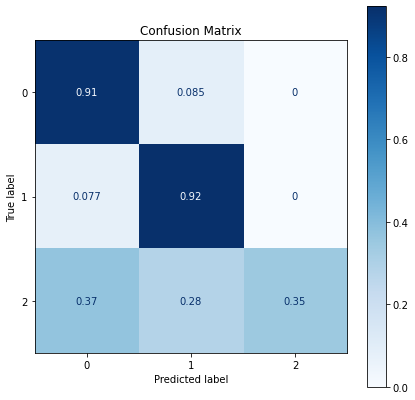

In [45]:
#calculate feature importances
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(model_v3.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print('Importances')
print(importances)
print('\n')  
    
#print classification report
print('Classification report')
predict_val = model_v3.predict(X_val)
print(classification_report(y_val, predict_val))
print('\n')
    
#print normalized confusion matrix   
matrix = plot_confusion_matrix(model_v3, X_val, y_val, cmap=plt.cm.Blues, normalize='true')
matrix.ax_.set_title('Confusion Matrix')
fig = plt.gcf()
fig.set_size_inches(7, 7)
plt.show()